In [3]:
import os
import json
import math
import numpy as np 
import time

import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
from matplotlib.colors import to_rgb
import matplotlib
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms

import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

from tqdm.notebook import tqdm

import urllib.request
from urllib.error import HTTPError

from HelperFunc import plot_graph


# Init and Downloading

In [4]:
%matplotlib inline 
matplotlib.rcParams['lines.linewidth'] = 2.0
sns.reset_orig()
sns.set()

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "./tmp_dataset"
os.makedirs(DATASET_PATH, exist_ok=True)
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "./tmp_saved_models/"
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# mps is for apple macbooks
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
# this sets the default device for all torch operations, to avoid unexpected conflicts
print(device)

Seed set to 42


mps


In [5]:
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial7/"
# Files to download
pretrained_files = ["NodeLevelMLP.ckpt", "NodeLevelGNN.ckpt", "GraphLevelGraphConv.ckpt"]

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if "/" in file_name:
        os.makedirs(file_path.rsplit("/",1)[0], exist_ok=True)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)

## Graph representation

Mathematically, a graph ($\mathcal{G}$) is defined as a tuple of a set of nodes/vertices ($V$), and a set of edges/links ( $E$: $\mathcal{G}=(V,E)$ ). For instance:

<center width="100%" style="padding:10px"><img src="supplementary/example_graph.svg" width="250px"></center>

- Vertices $V=\{1,2,3,4\}$
- Edges $E=\{(1,2), (2,3), (2,4), (3,4)\}$
- We assume the graph to be undirected and hence don't add mirrored pairs like $(2,1)$

For an undirected graph, $A$ is a symmetric matrix ($A_{ij}=A_{ji}$). We have the following adjacency matrix:

$$
A = \begin{bmatrix}
    0 & 1 & 0 & 0\\
    1 & 0 & 1 & 1\\
    0 & 1 & 0 & 1\\
    0 & 1 & 1 & 0
\end{bmatrix}
$$

- Expressing a graph as a **list of edges** is **more efficient** in terms of memory and (possibly) computation, but using an adjacency matrix simpler to implement.
- _We will implement the adjacency matrix_ to keep the code simple.
- Alternatively, we could also use the list of edges to _define a sparse adjacency matrix_ with which we can work as if it was a dense matrix, but allows more memory-efficient operations.


## Graph Convolutions

- GCNs are similar to convolutions in images in the sense that the “filter” parameters are typically shared over all locations in the graph.
- At the same time, GCNs rely on message passing methods, which means that vertices exchange information with the neighbors, and send “messages” to each other.

1. The first step is that each node creates a feature vector that represents the message it wants to send to all its neighbors.
2. In the second step, the messages are sent to the neighbors, so that a node receives one message per adjacent node. 

Below we have visualized the two steps for our example graph. 

<center width="100%" style="padding:10px"><img src="graph_message_passing.svg" width="700px"></center>

**How to combine all the messages a node receives?**<br>
As the number of messages vary across nodes, we need an operation that works for any number. Hence, **sum** or **take the mean.**.
The GCN layer is defined as follows:

$$H^{(l+1)} = \sigma\left(\hat{D}^{-1/2}\hat{A}\hat{D}^{-1/2}H^{(l)}W^{(l)}\right)$$

Looking at the equation from **right to left:**

$H^{(l)}$ : the previous features of **all** nodes. Each row represents the feature vector of a node.

$W^{(l)}$ :  the weight matrix of learnable parameters at layer $l$.

$H^{(l)}W^{(l)}$ : the weighted average of the previous features (new messages)

$A$ : the adjacency matrix

$\hat{A}=A+I$ : we add the identity matrix to the adjacency matrix so that each node sends its own message to itself too

$\hat{D}$ : the diagonal degree matrix corresponding to $\hat{A}$, where each diagonal entry $D_{ii}$ represents the number of neighbors (including itself, due to $I$) of node $i$. This matrix is used for normalization purposes.

$\hat{D}^{-1/2}$ : is the inverse square root of the degree matrix. For a diagonal matrix, this operation is performed element-wise on the diagonal.

$\hat{D}^{-1/2}\hat{A}\hat{D}^{-1/2}$ : this term serves as a normalization technique for the adjacency matrix, preventing the scale of node features from growing or shrinking drastically as they propagate through the network layers. In other words, this normalization ensures that nodes with many connections don't overwhelm the computation, and nodes with fewer connections aren't overlooked.

$\sigma$ : represents an arbitrary activation function, and not necessarily the sigmoid (usually a ReLU-based activation function is used in GNNs).

$H^{(l+1)}$ : the new (current) features of **all** nodes

> Note: the standard matrix multiplication is the dot product, for example in $H^{(l)}W^{(l)}$.

In [6]:
class GCNLayer(nn.Module):
    def __init__(self, c_in, c_out):
        """
        Args:
            c_in (int): Number of input features per node.
            c_out (int): Number of output features per node.
        """
        super().__init__()

        # the weight matrix W in the GCN equation
        # a linear transformation layer to project input features to output features
        self.projection = nn.Linear(c_in, c_out)

    def forward(self, node_feats, adj_matrix):
        """
        The forward pass.
        Assumes identity connections (i.e., self-connections) are already added to the adjacency matrix.

        Args:
            node_feats: Node feature tensor of shape [batch_size, num_nodes, c_in]
            adj_matrix: Adjacency matrix tensor of shape [batch_size, num_nodes, num_nodes]
        Returns:
            Updated node features of shape [batch_size, num_nodes, c_out]
        """
        # Calculate the number of neighbors (incoming edges) for each node by summing over the last dimension of the adjacency matrix. The resulting tensor has shape [batch_size, num_nodes, 1], where each value represents the number of neighbors
        num_neighbours = adj_matrix.sum(dim=-1, keepdims=True)

        # Project node features using the weight matrix W
        new_node_feats = self.projection(node_feats)

        # matrix multiplication of adjacency matrix and each node features
        # aggregating features from neighboring nodes for each node
        # from: https://pytorch.org/docs/stable/generated/torch.bmm.html
        # if mat1 is (b×n×m) and mat2 is (b×m×p), the result will be a (b×n×p) tensor
        av_node_feats = torch.bmm(adj_matrix, new_node_feats)

        # Normalize the aggregated features by dividing by the number of neighbors.
        # This takes the mean of the neighbors' features instead of summing.
        # Shape remains [batch_size, num_nodes, c_out]
        norm_node_feats = av_node_feats / num_neighbours

        return norm_node_feats


## Simple Intution
1. **Single Graph:** We have one graph with `n` nodes.
2. **Node Features:** Each node has `m` features. These features are typically represented as a vector, not a matrix, for each node.
3. **Graph Representation with Adjacency Matrix:** `[n, n]` shape, representing connections between nodes.
4. **Node Features:** `[n, m]` shape, where each row represents the features of a node.
5. **GCN Layer Operation:** In each GCN layer, the features of each node are combined with those of its connected nodes, and a weighted average is calculated.
6. **Output:** The output of each GCN layer is a new set of node features, still maintaining the `[n, m']` shape (where `m'` might be different from `m` if the layer changes the feature dimension).

### Why do we need a batch of graphs if we are working with one graph?!
This is answered below after the example.

### Example

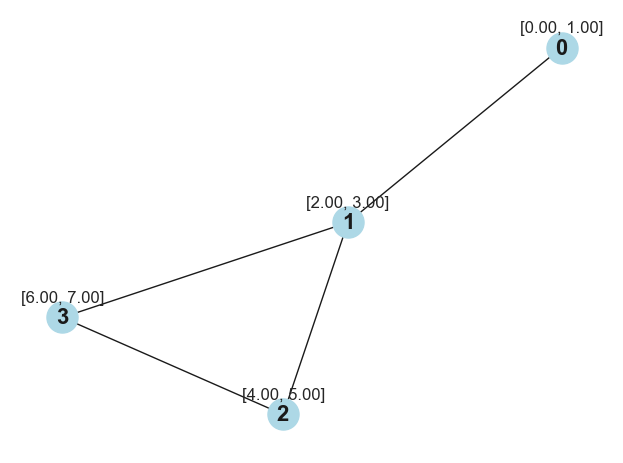

In [8]:
# 1 graph (adj_matrix batch), 4 nodes per batch, 2 features per node
node_feats = torch.arange(8, dtype=torch.float32).view(1, 4, 2)

# note that the identity connections are already included in the adjacency matrix
adj_matrix = torch.Tensor([[[1, 1, 0, 0],
                            [1, 1, 1, 1],
                            [0, 1, 1, 1],
                            [0, 1, 1, 1]]])

# print("Node features:\n", node_feats)
fig, ax = plot_graph(adj_matrix, node_feats)
plt.show()
plt.close()

For simplicity, we initialize the linear weight matrix as an identity matrix so that the input features are equal to the messages. This makes it easier for us to verify the message passing operation.

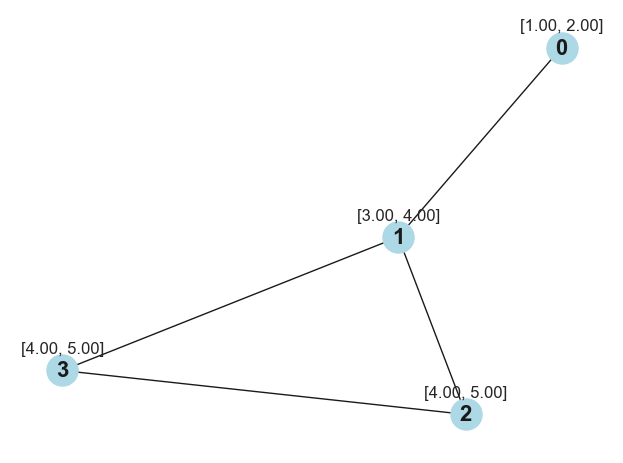

In [12]:
layer = GCNLayer(c_in=node_feats.to(device).shape[-1], c_out=2)
layer.projection.weight.data = torch.Tensor([[1., 0.], [0., 1.]])
layer.projection.bias.data = torch.Tensor([0., 0.])

with torch.no_grad():
    out_feats = layer(node_feats, adj_matrix)

plot_graph(adj_matrix, out_feats.cpu())
plt.show()
plt.close()

As we can see, the first node's output values are the average of itself and the second node. Similarly, we can verify all other nodes. However, **in a GNN,** we would also want to allow feature exchange between nodes beyond its neighbors. This can be achieved by applying multiple GCN layers, which gives us the final layout of a GNN. **The GNN can be build up by a sequence of GCN layers and non-linearities such as ReLU.** For a visualization, see below (figure credit - [Thomas Kipf, 2016](https://tkipf.github.io/graph-convolutional-networks/)).

<center width="100%" style="padding: 10px"><img src="gcn_network.png" width="600px"></center>

However, one issue in the example above is that the output features for nodes 3 and 4 are the same because they have the same adjacent nodes (including itself). Therefore, **GCN layers can make the network forget node-specific information if we just take a mean over all messages.**
Possible fixes:
- The simplest option might be using residual connections
- The more common approach is to weigh the self-connections higher, or
- Define a separate weight matrix for the self-connections, or
- Use attention

### Graph Attention 

If you remember from the last tutorial, attention describes a weighted average of multiple elements with the weights dynamically computed based on an input query and elements' keys (if you haven't read Tutorial 6 yet, it is recommended to at least go through the very first section called [What is Attention?](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial6/Transformers_and_MHAttention.html#What-is-Attention?)). This concept can be similarly applied to graphs, one of such is the Graph Attention Network (called GAT, proposed by [Velickovic et al., 2017](https://arxiv.org/abs/1710.10903)). Similarly to the GCN, the graph attention layer creates a message for each node using a linear layer/weight matrix. For the attention part, it uses the message from the node itself as a query, and the messages to average as both keys and values (note that this also includes the message to itself). The score function $f_{attn}$ is implemented as a one-layer MLP which maps the query and key to a single value. The MLP looks as follows (figure credit - [Velickovic et al.](https://arxiv.org/abs/1710.10903)):

<center width="100%" style="padding:10px"><img src="graph_attention_MLP.svg" width="250px"></center>

$h_i$ and $h_j$ are the original features from node $i$ and $j$ respectively, and represent the messages of the layer with $\mathbf{W}$ as weight matrix. $\mathbf{a}$ is the weight matrix of the MLP, which has the shape $[1,2\times d_{\text{message}}]$, and $\alpha_{ij}$ the final attention weight from node $i$ to $j$. The calculation can be described as follows:

$$\alpha_{ij} = \frac{\exp\left(\text{LeakyReLU}\left(\mathbf{a}\left[\mathbf{W}h_i||\mathbf{W}h_j\right]\right)\right)}{\sum_{k\in\mathcal{N}_i} \exp\left(\text{LeakyReLU}\left(\mathbf{a}\left[\mathbf{W}h_i||\mathbf{W}h_k\right]\right)\right)}$$

The operator $||$ represents the concatenation, and $\mathcal{N}_i$ the indices of the neighbors of node $i$. Note that in contrast to usual practice, we apply a non-linearity (here LeakyReLU) before the softmax over elements. Although it seems like a minor change at first, it is crucial for the attention to depend on the original input. Specifically, let's remove the non-linearity for a second, and try to simplify the expression:

$$
\begin{split}
    \alpha_{ij} & = \frac{\exp\left(\mathbf{a}\left[\mathbf{W}h_i||\mathbf{W}h_j\right]\right)}{\sum_{k\in\mathcal{N}_i} \exp\left(\mathbf{a}\left[\mathbf{W}h_i||\mathbf{W}h_k\right]\right)}\\[5pt]
    & = \frac{\exp\left(\mathbf{a}_{:,:d/2}\mathbf{W}h_i+\mathbf{a}_{:,d/2:}\mathbf{W}h_j\right)}{\sum_{k\in\mathcal{N}_i} \exp\left(\mathbf{a}_{:,:d/2}\mathbf{W}h_i+\mathbf{a}_{:,d/2:}\mathbf{W}h_k\right)}\\[5pt]
    & = \frac{\exp\left(\mathbf{a}_{:,:d/2}\mathbf{W}h_i\right)\cdot\exp\left(\mathbf{a}_{:,d/2:}\mathbf{W}h_j\right)}{\sum_{k\in\mathcal{N}_i} \exp\left(\mathbf{a}_{:,:d/2}\mathbf{W}h_i\right)\cdot\exp\left(\mathbf{a}_{:,d/2:}\mathbf{W}h_k\right)}\\[5pt]
    & = \frac{\exp\left(\mathbf{a}_{:,d/2:}\mathbf{W}h_j\right)}{\sum_{k\in\mathcal{N}_i} \exp\left(\mathbf{a}_{:,d/2:}\mathbf{W}h_k\right)}\\
\end{split}
$$

We can see that without the non-linearity, the attention term with $h_i$ actually cancels itself out, resulting in the attention being independent of the node itself. Hence, we would have the same issue as the GCN of creating the same output features for nodes with the same neighbors. This is why the LeakyReLU is crucial and adds some dependency on $h_i$ to the attention. 

Once we obtain all attention factors, we can calculate the output features for each node by performing the weighted average:

$$h_i'=\sigma\left(\sum_{j\in\mathcal{N}_i}\alpha_{ij}\mathbf{W}h_j\right)$$

$\sigma$ is yet another non-linearity, as in the GCN layer. Visually, we can represent the full message passing in an attention layer as follows (figure credit - [Velickovic et al.](https://arxiv.org/abs/1710.10903)):

<center width="100%"><img src="graph_attention.jpeg" width="400px"></center>

To increase the expressiveness of the graph attention network, [Velickovic et al.](https://arxiv.org/abs/1710.10903) proposed to extend it to multiple heads similar to the Multi-Head Attention block in Transformers. This results in $N$ attention layers being applied in parallel. In the image above, it is visualized as three different colors of arrows (green, blue, and purple) that are afterward concatenated. The average is only applied for the very final prediction layer in a network. 

After having discussed the graph attention layer in detail, we can implement it below:

In [ ]:
class GATLayer(nn.Module):
    
    def __init__(self, c_in, c_out, num_heads=1, concat_heads=True, alpha=0.2):
        """
        Inputs:
            c_in - Dimensionality of input features
            c_out - Dimensionality of output features
            num_heads - Number of heads, i.e. attention mechanisms to apply in parallel.
            concat_heads - If True, the output of the different heads is concatenated instead of averaged. In other words, the output features are equally split up over the heads if concat_heads=True.
            alpha - Negative slope of the LeakyReLU activation.
        """
        super().__init__()
        self.num_heads = num_heads
        self.concat_heads = concat_heads
        if self.concat_heads:
            assert c_out % num_heads == 0, "Number of output features must be a multiple of the count of heads."
            c_out = c_out // num_heads
        
        # Sub-modules and parameters needed in the layer
        self.projection = nn.Linear(c_in, c_out * num_heads)

        # Remember that "vector a" is the weight matrix of the MLP, that represents the weight vector used to compute attention coefficients between nodes
        self.a = nn.Parameter(torch.Tensor(num_heads, 2 * c_out)) # One per head
        self.leakyrelu = nn.LeakyReLU(alpha)
        
        # Initialization from the original implementation
        nn.init.xavier_uniform_(self.projection.weight.data, gain=1.414)
        nn.init.xavier_uniform_(self.a.data, gain=1.414)
        
    def forward(self, node_feats, adj_matrix, print_attn_probs=False):
        """
        Inputs:
            node_feats - Input features of the node. Shape: [batch_size, c_in]
            adj_matrix - Adjacency matrix including self-connections. Shape: [batch_size, num_nodes, num_nodes]
            print_attn_probs - If True, the attention weights are printed during the forward pass (for debugging purposes)
        """
        batch_size, num_nodes = node_feats.size(0), node_feats.size(1)
        
        # Apply linear layer and sort nodes by head
        node_feats = self.projection(node_feats)
        node_feats = node_feats.view(batch_size, num_nodes, self.num_heads, -1)
        
        # We need to calculate the attention logits for every edge in the adjacency matrix 
        # Doing this on all possible combinations of nodes is very expensive
        # => Create a tensor of [W*h_i||W*h_j] with i and j being the indices of all edges
        edges = adj_matrix.nonzero(as_tuple=False) # Returns indices where the adjacency matrix is not 0 => edges
        node_feats_flat = node_feats.view(batch_size * num_nodes, self.num_heads, -1)
        edge_indices_row = edges[:,0] * num_nodes + edges[:,1]
        edge_indices_col = edges[:,0] * num_nodes + edges[:,2]
        a_input = torch.cat([
            torch.index_select(input=node_feats_flat, index=edge_indices_row, dim=0),
            torch.index_select(input=node_feats_flat, index=edge_indices_col, dim=0)
        ], dim=-1) # Index select returns a tensor with node_feats_flat being indexed at the desired positions along dim=0
        
        # Calculate attention MLP output (independent for each head)
        attn_logits = torch.einsum('bhc,hc->bh', a_input, self.a) 
        attn_logits = self.leakyrelu(attn_logits)
        
        # Map list of attention values back into a matrix
        attn_matrix = attn_logits.new_zeros(adj_matrix.shape+(self.num_heads,)).fill_(-9e15)
        attn_matrix[adj_matrix[...,None].repeat(1,1,1,self.num_heads) == 1] = attn_logits.reshape(-1)
        
        # Weighted average of attention
        attn_probs = F.softmax(attn_matrix, dim=2)
        if print_attn_probs:
            print("Attention probs\n", attn_probs.permute(0, 3, 1, 2))
        node_feats = torch.einsum('bijh,bjhc->bihc', attn_probs, node_feats)
        
        # If heads should be concatenated, we can do this by reshaping. Otherwise, take mean
        if self.concat_heads:
            node_feats = node_feats.reshape(batch_size, num_nodes, -1)
        else:
            node_feats = node_feats.mean(dim=2)
        
        return node_feats 